Train on 80000 samples, validate on 10000 samples
Epoch 1/100
80000/80000 [==============================] - 1s 16us/step - loss: 0.6957 - acc: 0.5628 - val_loss: 0.6623 - val_acc: 0.6121
Epoch 2/100
80000/80000 [==============================] - 1s 10us/step - loss: 0.6548 - acc: 0.6067 - val_loss: 0.6357 - val_acc: 0.5998
Epoch 3/100
80000/80000 [==============================] - 1s 10us/step - loss: 0.6375 - acc: 0.6086 - val_loss: 0.6322 - val_acc: 0.6013
Epoch 4/100
80000/80000 [==============================] - 1s 9us/step - loss: 0.6288 - acc: 0.6079 - val_loss: 0.6221 - val_acc: 0.5975
Epoch 5/100
80000/80000 [==============================] - 1s 9us/step - loss: 0.6237 - acc: 0.6047 - val_loss: 0.6189 - val_acc: 0.6153
Epoch 6/100
80000/80000 [==============================] - 1s 10us/step - loss: 0.6183 - acc: 0.6045 - val_loss: 0.6114 - val_acc: 0.5992
Epoch 7/100
80000/80000 [==============================] - 1s 10us/step - loss: 0.6116 - acc: 0.6094 - val_loss: 0.6065 - va

80000/80000 [==============================] - 1s 9us/step - loss: 0.1776 - acc: 0.9458 - val_loss: 0.1745 - val_acc: 0.9463
Epoch 60/100
80000/80000 [==============================] - 1s 9us/step - loss: 0.1796 - acc: 0.9447 - val_loss: 0.1792 - val_acc: 0.9478
Epoch 61/100
80000/80000 [==============================] - 1s 10us/step - loss: 0.1798 - acc: 0.9442 - val_loss: 0.1813 - val_acc: 0.9463
Epoch 62/100
80000/80000 [==============================] - 1s 10us/step - loss: 0.1774 - acc: 0.9449 - val_loss: 0.1836 - val_acc: 0.9436
Epoch 63/100
80000/80000 [==============================] - 1s 11us/step - loss: 0.1770 - acc: 0.9455 - val_loss: 0.1835 - val_acc: 0.9444
Epoch 64/100
80000/80000 [==============================] - 1s 10us/step - loss: 0.1742 - acc: 0.9465 - val_loss: 0.1813 - val_acc: 0.9457
Epoch 65/100
80000/80000 [==============================] - 1s 10us/step - loss: 0.1757 - acc: 0.9448 - val_loss: 0.1806 - val_acc: 0.9453
Epoch 66/100
80000/80000 [================

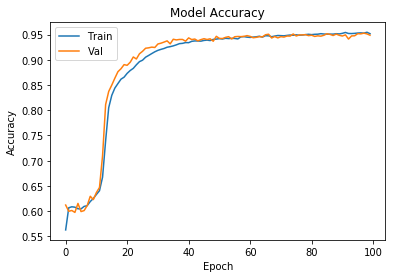

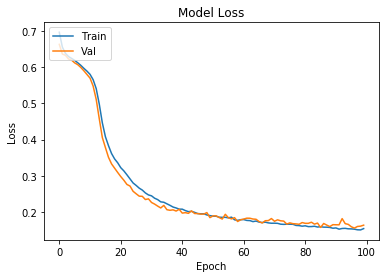

10000/10000 [==============================] - 0s 11us/step

               precision    recall  f1-score   support

         0.0       0.94      0.95      0.95      4872
         1.0       0.95      0.95      0.95      5128

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

10000/10000 [==============================] - 0s 2us/step


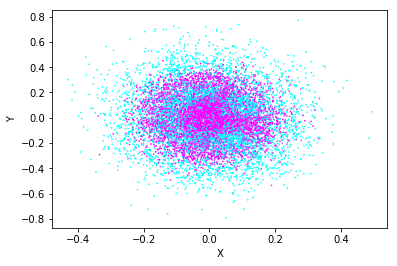

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 30 11:16:40 2018

@author: rossh

"""
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from contrastive import CPCA
from sklearn.metrics import classification_report
from sklearn.neighbors.kde import KernelDensity
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.regularizers import l2
import matplotlib.pyplot as plt

run_kde = False
n_features = 2

# loading train.txt value
data = pd.read_csv('train.txt', sep=' ', header=None) # pandas used as it automatically parses scientific notation
xy_data = data.loc[:,1:].values # get as array
# splitting data into train and test data 80:20
X_train, X_test, y_train, y_test = train_test_split( xy_data[:,:8], xy_data[:,8], test_size=0.20, shuffle=False)

classification_One = X_train[y_train[:] == 1, :8] # all points labeled 1 by KNN classification 
#classification_Zero = X_train[y_train[:] == 0, :8] # all points labeled 0 by KNN classification 

# performing contrastive principal componenet analysis
mdl = CPCA(n_components = n_features)
CPCA_train = mdl.fit_transform(X_train, classification_One, alpha_selection='manual', alpha_value=12)
CPCA_test = mdl.fit_transform(X_test, classification_One[:10000,:], alpha_selection='manual', alpha_value=12)
CPCA_test[:,1] = np.negative(CPCA_test[:,1]) # inverted y axis as data loaded inverted

# calculate kernel denisty estimations(takes a while to complete)
if run_kde == True:
    kde_train = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(CPCA_train)
    result_train = kde_train.score_samples(CPCA_train)
    np.savetxt('classDensity_train.txt', result_train)
    
    kde_test = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(CPCA_test)
    result_test = kde_test.score_samples(CPCA_test)
    np.savetxt('classDensity_test.txt', result_test)

classDensity_train = np.loadtxt('classDensity_train.txt')
classDensity_test = np.loadtxt('classDensity_test.txt')

# assembling training feature set
train_ = np.zeros((len(CPCA_train), n_features+9))
train_[:,:n_features] = CPCA_train # cPCA 2D reduced feature set
train_[:,n_features:n_features+8] = X_train # original 8 dimensonal feature set
train_[:,n_features+8] = classDensity_train # Results of KDE
X_train = train_

# assembling test feature set
test_ = np.zeros((len(CPCA_test), n_features+9))
test_[:,:n_features] = CPCA_test # cPCA 2D reduced feature set
test_[:,n_features:n_features+8] = X_test # original 8 dimensonal feature set
test_[:,n_features+8] = classDensity_test # Results of KDE

# Splitting test set into test and validation 50:50
X_valid = test_[:int(len(y_test)/2), :]
X_test = test_[int(len(y_test)/2):, :]
y_valid = y_test[:int(len(y_test)/2)]
y_test = y_test[int(len(y_test)/2):]

# Sequentail Model https://github.com/Msanjayds/Keras/blob/master/Classification_Model_using_Keras.ipynb
model = Sequential()
# Hidden Layer-1
model.add(Dense(100,activation='relu',input_dim=11,kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.05, noise_shape=None, seed=None))
# Hidden Layer-2
model.add(Dense(100,activation='relu',kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.05, noise_shape=None, seed=None))
# Output layer
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model_output = model.fit(X_train,y_train,epochs=100,batch_size=1000,verbose=1,validation_data=(X_valid,y_valid),)

print("\nFinal Training Accuracy", model_output.history['acc'][-1],
      "\nFinal Training Loss", model_output.history['loss'][-1],
      "\nFinal Validation Accuracy", model_output.history['val_acc'][-1],
      "\nFinal Validation Loss", model_output.history['val_loss'][-1])

print('\nMean Training Accuracy : ' , np.mean(model_output.history["acc"]))
print('Mean Validation Accuracy : ' , np.mean(model_output.history["val_acc"]))

# Plot training & validation accuracy values
plt.plot(model_output.history['acc'])
plt.plot(model_output.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

# Plot training & validation loss values
plt.plot(model_output.history['loss'])
plt.plot(model_output.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

# Test set classification report 
y_pred = model.predict(X_test,batch_size=1000, verbose=1)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.

print("\n",classification_report(y_test, y_pred))

# Loading test.txt dataset and pre processing
data = pd.read_csv('test.txt', sep=' ', header=None) # pandas used as it automatically parses scientific notation
X_data = data.loc[:,1:].values # getting as array
# Performing Contrastive Principal Componenet Analysis
CPCA_data = mdl.fit_transform(X_data, classification_One[:len(X_data),:], alpha_selection='manual', alpha_value=12)
CPCA_data[:,0] = np.negative(CPCA_data[:,0]) # inverted X axis as data loaded inverted

# calculate kernel denisty estimations(takes a while to complete)
if run_kde == True:
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(CPCA_data)
    result = kde.score_samples(CPCA_data)
    np.savetxt('classDensity_data.txt', result)

classDensity_data = np.loadtxt('classDensity_data.txt')

# Assembling final feature set 
testData_ = np.zeros((len(CPCA_data), n_features+9))
testData_[:,:n_features] = CPCA_data # cPCA 2D reduced feature set
testData_[:,n_features:n_features+8] = X_data # original 8 dimensonal feature set
testData_[:,n_features+8] = classDensity_data # Results of KDE
X_data = testData_

data_y_pred = model.predict(X_data,batch_size=1000, verbose=1) # Predicting with model 
np.savetxt('test-labels.txt', data_y_pred)

data_y_pred = data_y_pred.ravel() # flatten for plotting
# Plotting test.txt data and coloring by predicted label
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots(1, 1)
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(CPCA_data[:,0], CPCA_data[:,1], c=data_y_pred, cmap=plt.cool(),s=0.4)
plt.show();